### Import all packages

In [4]:
# from hw2
import pydub
from pydub import AudioSegment
import pydub
from pydub.playback import play
from python_speech_features import mfcc
from python_speech_features import logfbank
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from time import sleep
import scipy.io.wavfile as wav
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
import torch

### Preparing the dataset

In [114]:
downloaded_files = glob(f"./data/audios/*.mp3")
num_downloaded_files = len(downloaded_files)

In [97]:
dev = pd.read_csv("./data/tsvs/dev.tsv", sep="\t")
train = pd.read_csv("./data/tsvs/train.tsv", sep="\t")
test = pd.read_csv("./data/tsvs/test.tsv", sep="\t")
validated = pd.read_csv("./data/tsvs/validated.tsv", sep="\t")
invalidated = pd.read_csv("./data/tsvs/invalidated.tsv", sep="\t")

splits = {
    "dev": dev,
    "train": train, 
    "test": test,
    "validated": validated,
    "invalidated": invalidated
}

#### Fix the paths

In [98]:
prefix = "./data/audios/"
for key in splits:
    splits[key]['path'] = prefix + splits[key]['path'].astype(str)

#### Drop the rows with NaN accent values

In [99]:
for key in splits:
    print(len(splits[key]))

15531
232975
15531
218400
124820


In [100]:
for key in splits:
    splits[key].dropna(axis=0, subset=["accent"], inplace=True)
    print(len(splits[key]))

2100
135391
1398
46169
46728


#### Choose the data we've actually downloaded

In [101]:
for key in splits:
    splits[key] = splits[key][splits[key]["path"].isin(downloaded_files)]
    print(len(splits[key]))

2
414
2
41
76


#### Make sure speaker independent and validated

In [107]:
len(splits['train'][splits['train']["client_id"].isin(splits['test']['client_id'])])

0

In [108]:
len(splits['train'][splits['train']["client_id"].isin(splits['dev']['client_id'])])

0

In [118]:
num_train = len(splits['train'][splits['train']["client_id"].isin(splits['validated']['client_id'])])
num_test = len(splits['test'][splits['test']["client_id"].isin(splits['validated']['client_id'])])
num_dev = len(splits['dev'][splits['dev']["client_id"].isin(splits['validated']['client_id'])])

print(f"Wow, we only end up with {num_train} training, {num_test} test and {num_dev} dev audio files from the {num_downloaded_files} files we started with!")

Wow, we only end up with 37 training, 2 test and 2 dev audio files from the 900 files we started with!


#### For the purposes of this toy example we forgoe using only the validated clips and assume all clips are good. 

#### Lets take a look at some of our data

In [140]:
# visualize categorical data https://www.datacamp.com/community/tutorials/categorical-data
def visualize_categorical_distribution(pd_series, title="Plot", ylabel='Number of Samples', xlabel='Accent', figsize=None):
    digit_counts = pd_series.value_counts()
    sns.set(style="darkgrid")
    if figsize is None:
        sns.set(rc={'figure.figsize':(10,6)})
    else:
        sns.set(rc={'figure.figsize':figsize})
    sns.barplot(digit_counts.index, digit_counts.values, alpha=0.9)
    plt.title(title)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)
    plt.show()

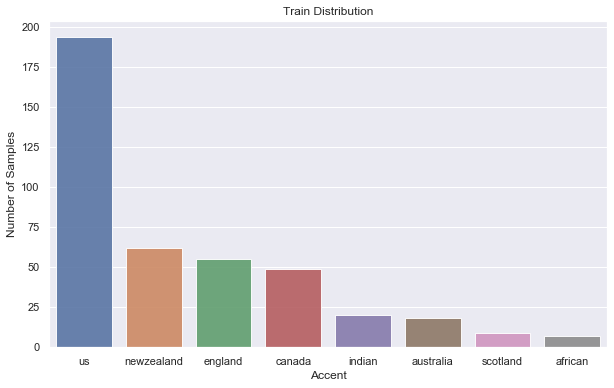

In [141]:
visualize_categorical_distribution(splits["train"]["accent"], "Train Distribution")

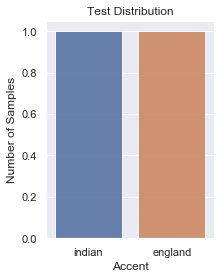

In [142]:
visualize_categorical_distribution(splits["test"]["accent"], "Test Distribution", figsize=(3,4))

# Yikes

#### Lets start adding our actual audio files to the dataset

#### TODO: Creating our Toy Models